# Lab 04 Monte Carlo Methods

In the last lab, we were trying to do **Makov Decision Process (MDP)** and **Dynamics programing (DP)**. They require the environment to be fully known, including *transition Matrix* and *reward matrix*. The disadvantage of the algorithm is they have limit size of environment. These algorithms are called **model-base approach**.

In this lab, we will look another algorithm which have no required the prior knowledge of the environment, and it can scalable environment than DP -- This is called **Model-Free approach**. The algorithm is called **Monte Carlo Methods (MC)**.

MC can predict state values and state-action values in a first-visit and every-visit manner. The process is used for exploration and exploitation. MC can be implemented with on-policy and off-policy to find optimal policy.

## Monte Carlo Method Concept

MC method is any mothod that uses randomness to solve problems. The algorithm repeats suitable **random sampling** and observes the fraction of samples that obey particular properties in order to make numerical estimations.

## Find $\pi$ using MC method

$\pi$? Yes the $\pi$ which is used for calculate circle. We assume that if there are some random points which are in the square area. We can calculate $\pi$ by

$$ A_{rect} = (2r)^2 = 4r^2 $$
$$ A_{circle} = \pi r^2 $$

Hence,
$$ \frac{A_{circle}}{A_{rect}} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4} $$

Let's try to code:

In [1]:
import torch
import numpy
import math
import matplotlib.pyplot as plt

Random 2,000 points in the square $x \in [-1,1]$ and $y \in [-1,1]$

In [2]:
n_point = 2000
points = torch.rand((n_point, 2)) * 2 - 1

Find the points which are inside the circle, and keep them (this is for plot in the graph only)

In [3]:
points_circle_x = []
points_circle_y = []
n_point_circle = 0

pi_iteration = []
i = 1
for point in points:
    r = torch.sqrt(point[0] ** 2 + point[1] ** 2)
    if r <= 1:
        points_circle_x.append(point[0])
        points_circle_y.append(point[1])
        n_point_circle += 1
    pi_iteration.append(4 * (n_point_circle / i))
    i += 1
        
points_circle_x = numpy.asarray(points_circle_x)
points_circle_y = numpy.asarray(points_circle_y)

Find the estimate $\pi$

In [4]:
pi_estimated = 4 * n_point_circle / n_point
print('Estimated value of pi is:', pi_estimated)

Estimated value of pi is: 3.098


Plot to show the points and circle

<ipython-input-5-4bdf5c008734>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  i = torch.linspace(0, 2 * math.pi)
<ipython-input-5-4bdf5c008734>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


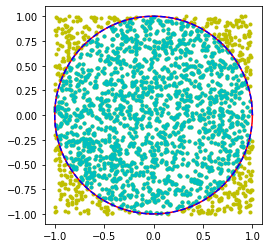

In [5]:
plt.plot(points[:, 0].numpy(), points[:, 1].numpy(), 'y.')
plt.plot(points_circle_x, points_circle_y, 'c.')
# plot real circle
i = torch.linspace(0, 2 * math.pi)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy(), 'r-')
# plot circle from estimate pi
i = torch.linspace(0, 2 * pi_estimated)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy(), 'b--')
plt.axes().set_aspect('equal')
plt.show()

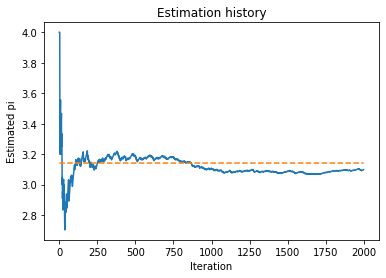

In [6]:
plt.plot(pi_iteration)
plt.plot([math.pi] * n_point, '--')
plt.xlabel('Iteration')
plt.ylabel('Estimated pi')
plt.title('Estimation history')
plt.show()

### Monte Carlo Policy Evaluation

Last time, we applied **DP** algorithm into policy evaluation. The things we need are:

- Full state-value transition matrix
- Reward matrix

Those are fully known environment. However, in real-life situation, we don't know before we reach the situation. This is the **limitation of model-base algorithm**. To address the problem, the **model-free algorithm** is created for no pre-required prior knowledge both transition and rewards matrices.

We need to recall the returns of **Giving Policy (G)** from a process, which are the total rewards over the long run, 

$$G_t=\sum_k \gamma^k R_{t+k+1}$$

MC policy evaluation uses **empirical mean return** instead of **expected return (as in DP)** to estimate the value function. There are two ways to perform MC policy evaluation.
- First-visit MC prediction -- averages the returns only for the first occurrence of a state, s, in an episode. 
- Every-visit MC prediction -- averages the returns for every occurrence of a state, s, in an episode.

First-visit MC prediction has fewer calculations than the every-visit version, so it is more frequently used.

### Incremental means

To update the MC method, the incremenatl means have been used for update the policy. An incremental or running mean allows us to keep an average for a list of numbers without having to remember the list. We hold one value that we incrementally update using the following equation:

$$V(S_t) = V(S_t) + \alpha(G_t + V(S_t))$$

When $V(S_t)$ is the current state value for the policy, $\alpha$ is a discount rate, and $G_t$.

### FrozenLake and First-visit MC policy evaluation

Let's start in FrozenLake environment using first-visit MC prediction.

In [7]:
import torch
import gym

env = gym.make("FrozenLake-v1")

/home/alisa/.local/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
/home/alisa/.local/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
/home/alisa/.local/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/NameThisGame-v5
  logger.warn("Overriding environment {}".format(id))
/home/alisa/.local/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/NameThisGame-ram-v5
  logger.warn("Overriding environment {}".format(id))
/home/alisa/.local/lib/python3.8/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Freeway-v5
  logger.warn("Overriding environment {}".format(id))
/home/alisa/.local/lib/python3.8/site-packag

Create a function which simulate for each episode given a policy and returns the reward and state for each step

In [8]:
def run_episode(env, policy):
    state = env.reset()
    # this is the difference between MC and DP, find rewards and states
    rewards = []
    states = [state]
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, info = env.step(action)
        # keep all states and reward
        states.append(state)
        rewards.append(reward)
        if is_done:
            break
    # convert to torch
    states = torch.tensor(states)
    rewards = torch.tensor(rewards)
    return states, rewards

Create MC prediction in first-visit.

In [9]:
def mc_prediction_first_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    for episode in range(n_episode):
        # run 1 episode until end of the episode
        states_t, rewards_t = run_episode(env, policy)
        return_t = 0
        first_visit = torch.zeros(n_state)
        G = torch.zeros(n_state)
        # take a look the state and reward from the last to first start
        # calculate given policy
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            # calculate rewards
            # because the reward at the last can be only 0 or 1, otherwise are 0
            # so the reward at first start will be smallest
            return_t = gamma * return_t + reward_t
            # put the reward for the state into given policy
            # as you can see, if we come in the same state, it will be replaced to the early time when visit
            # That's why we call first-visit
            G[state_t] = return_t
            first_visit[state_t] = 1
        # at the end of given policy calculation
        # we need to update the state transition by summation them (prepare to average)
        for state in range(n_state):
            if first_visit[state] > 0:
                V[state] += G[state]
                N[state] += 1
    # average state transition here
    for state in range(n_state):
        if N[state] > 0:
            V[state] = V[state] / N[state]
    return V

Setup discount rate $\gamma$ as 1 and simulate 10,000 episodes

We tried to used <code>optimal_policy</code> from lab 02 (don't be worry, we just bring the data), and feed it into the first-visit MC function, and see the results.

In [10]:
gamma = 1
n_episode = 10000

optimal_policy = torch.tensor([0., 3., 3., 3., 0., 3., 2., 3., 3., 1., 0., 3., 3., 2., 1., 3.])
value = mc_prediction_first_visit(env, optimal_policy, gamma, n_episode)
print('The value function calculated by first-visit MC prediction:\n', value)

The value function calculated by first-visit MC prediction:
 tensor([0.7404, 0.4985, 0.4918, 0.4425, 0.7404, 0.0000, 0.3788, 0.0000, 0.7404,
        0.7421, 0.6683, 0.0000, 0.0000, 0.8003, 0.8905, 0.0000])


As you can see, in MC-based prediction, it is not necessary to know about the full model of the environment. In most real-world cases, the transition matrix and reward matrix are not known beforehand, or are extremely difficult to obtain. Imagine how many possible states there are playing *chess* or *Go* and the number of possible actions; it is almost impossible to work out the transition matrix and reward matrix. Model-free reinforcement learning is about learning from experience by interacting with the environment.

We only considered what could be observed, which included the new state and reward in each step, and made predictions using the Monte Carlo method.

Note that the more episodes we simulate, the more accurate predictions we can obtain. If you plot the value updated after each episode, you will see how it converges over time, which is similar to what we saw when estimating the value of $\pi$.

### How about every-visit MC?

Take a look at every-visit MC function

In [11]:
def mc_prediction_every_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    G = torch.zeros(n_state)
    for episode in range(n_episode):
        states_t, rewards_t = run_episode(env, policy)
        return_t = 0
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            return_t = gamma * return_t + reward_t
            # Here is the difference, instead of discard the other visit
            # we calculate all visiting in the target state
            # That's why call every-visit
            G[state_t] += return_t
            N[state_t] += 1
    for state in range(n_state):
        if N[state] > 0:
            V[state] = G[state] / N[state]
    return V

In [12]:
e_value = mc_prediction_every_visit(env, optimal_policy, gamma, n_episode)
print('The value function calculated by every-visit MC prediction:\n', e_value)

The value function calculated by every-visit MC prediction:
 tensor([0.6191, 0.4092, 0.3563, 0.3043, 0.6150, 0.0000, 0.3459, 0.0000, 0.6286,
        0.6643, 0.6190, 0.0000, 0.0000, 0.7562, 0.8715, 0.0000])


Actually, the every-visit is more accurate than the first-visit, but it takes a lot of calculation, so it is not popular.

## Developing MC control with epsilon-greedy policy

The optimal policy using MC control can find the action with the highest state-action value was selected. However, the best choice available in early episodes does not guarantee an optimal solution. If we just focus on what is temporarily the best option and ignore the overall problem, we will be stuck in local optima instead of reaching the global optimal. In order to address the problem, we use another algorithm: epsilon-greedy policy.

In MC control with epsilon-greedy policy, we no longer exploit the best action all the time, but choose an action randomly under certain probabilities. As the name implies, the algorithm has two folds:

$$\pi(s,a) = \frac{\epsilon}{|A|}$$

when $|A|$ is the number of possible actions

#### Greedy

Greedy is the action with the highest state-action value is favored, and its probability of being chosen is increased by $1-\epsilon$:

$$\pi(s,a) = 1 - \epsilon + \frac{\epsilon}{|A|}$$

Epsilon-greedy policy exploits the best action most of the time and also keeps exploring different actions from time to time.

## Modify MC control with epsilon-greedy policy with FrozenLake

From the code above, let's modify as below:

In [13]:
import torch
import gym

env = gym.make("FrozenLake-v1")

Modify run_episode to return states, actions, rewards

In [14]:
def run_episode(env, Q, epsilon, n_action):
    """
    Run a episode and performs epsilon-greedy policy
    @param env: OpenAI Gym environment
    @param Q: Q-function
    @param epsilon: the trade-off between exploration and exploitation
    @param n_action: action space
    @return: resulting states, actions and rewards for the entire episode
    """
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

Create MC_control using epsilon greedy

In [15]:
from collections import defaultdict

def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon):
    """
    Obtain the optimal policy with on-policy MC control with epsilon_greedy
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param epsilon: the trade-off between exploration and exploitation
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        if (episode + 1) % 1000 == 0:
            print("Training episode {}".format(episode+1))
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action

            G_sum[state_action] += return_t
            N[state_action] += 1
            Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


Find optimal policy

In [16]:
gamma = 1

n_episode = 100000
epsilon = 0.1

optimal_Q, optimal_policy = mc_control_epsilon_greedy(env, gamma, n_episode, epsilon)

Training episode 1000
Training episode 2000
Training episode 3000
Training episode 4000
Training episode 5000
Training episode 6000
Training episode 7000
Training episode 8000
Training episode 9000
Training episode 10000
Training episode 11000
Training episode 12000
Training episode 13000
Training episode 14000
Training episode 15000
Training episode 16000
Training episode 17000
Training episode 18000
Training episode 19000
Training episode 20000
Training episode 21000
Training episode 22000
Training episode 23000
Training episode 24000
Training episode 25000
Training episode 26000
Training episode 27000
Training episode 28000
Training episode 29000
Training episode 30000
Training episode 31000
Training episode 32000
Training episode 33000
Training episode 34000
Training episode 35000
Training episode 36000
Training episode 37000
Training episode 38000
Training episode 39000
Training episode 40000
Training episode 41000
Training episode 42000
Training episode 43000
Training episode 440

To test the optimal policy, we need to run simulation using policy.

Let's create simulate_episode function:

In [17]:
def simulate_episode(env, policy):
    state = env.reset()
    is_done = False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

Run the optimal policy

In [18]:
n_episode = 50000
n_win_optimal = 0
n_lose_optimal = 0

for episode in range(n_episode):
    if (episode + 1) % 1000 == 0:
        print("Testing episode {}".format(episode+1))
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1

Testing episode 1000
Testing episode 2000
Testing episode 3000
Testing episode 4000
Testing episode 5000
Testing episode 6000
Testing episode 7000
Testing episode 8000
Testing episode 9000
Testing episode 10000
Testing episode 11000
Testing episode 12000
Testing episode 13000
Testing episode 14000
Testing episode 15000
Testing episode 16000
Testing episode 17000
Testing episode 18000
Testing episode 19000
Testing episode 20000
Testing episode 21000
Testing episode 22000
Testing episode 23000
Testing episode 24000
Testing episode 25000
Testing episode 26000
Testing episode 27000
Testing episode 28000
Testing episode 29000
Testing episode 30000
Testing episode 31000
Testing episode 32000
Testing episode 33000
Testing episode 34000
Testing episode 35000
Testing episode 36000
Testing episode 37000
Testing episode 38000
Testing episode 39000
Testing episode 40000
Testing episode 41000
Testing episode 42000
Testing episode 43000
Testing episode 44000
Testing episode 45000
Testing episode 460

In [19]:
print('Winning probability under the optimal policy: {}'.format(n_win_optimal/n_episode))

print('Losing probability under the optimal policy: {}'.format(n_lose_optimal/n_episode))

Winning probability under the optimal policy: 0.2723
Losing probability under the optimal policy: 0.0


## Implement other environments: LunarLander

Let's see the environment:

In [20]:
env = gym.make('LunarLander-v2')

See the simulator (using the code from lab 01)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

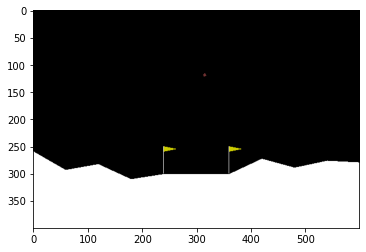

In [22]:
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break

ipythondisplay.clear_output(wait=True)
env.close()

Checking state in the environment.

In [23]:
state = env.reset()
print(state)

[ 0.00308781  1.4170799   0.31273767  0.27378237 -0.00357112 -0.07083981
  0.          0.        ]


Because the state is floating array, It is not good for creating the Q table. We try to change the state to integer array and convert the state array to tuple

In [24]:
state = tuple((state * 10).astype(int))
print(state)

(0, 14, 3, 2, 0, 0, 0, 0)


Modify run_episode function for supporting the state.

In [25]:
import numpy as np

def run_episode2(env, Q, epsilon, n_action):
    """
    Run a episode and performs epsilon-greedy policy
    @param env: OpenAI Gym environment
    @param Q: Q-function
    @param epsilon: the trade-off between exploration and exploitation
    @param n_action: action space
    @return: resulting states, actions and rewards for the entire episode
    """
    state = env.reset()
    state = tuple((state * 10).astype(int))
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = torch.ones(n_action) * epsilon / n_action
        #print(Q)
        #print(state)
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        state = tuple((state * 10).astype(int))
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

In [26]:
from collections import defaultdict

def mc_control_epsilon_greedy2(env, gamma, n_episode, epsilon):
    """
    Obtain the optimal policy with on-policy MC control with epsilon_greedy
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param epsilon: the trade-off between exploration and exploitation
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        if (episode + 1) % 5000 == 0:
            print("Training episode {}".format(episode+1))
        states_t, actions_t, rewards_t = run_episode2(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action

            G_sum[state_action] += return_t
            N[state_action] += 1
            Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


In [27]:
gamma = 0.5

n_episode = 100000
epsilon = 0.1

optimal_Q, optimal_policy = mc_control_epsilon_greedy2(env, gamma, n_episode, epsilon)

Training episode 5000
Training episode 10000
Training episode 15000
Training episode 20000
Training episode 25000
Training episode 30000
Training episode 35000
Training episode 40000
Training episode 45000
Training episode 50000
Training episode 55000
Training episode 60000
Training episode 65000
Training episode 70000
Training episode 75000
Training episode 80000
Training episode 85000
Training episode 90000
Training episode 95000
Training episode 100000


In [29]:
len(optimal_policy)

1704930

In [30]:
def simulate_episode_render(env, policy):
    state = env.reset()
    state = tuple((state * 10).astype(int))
    is_done = False
    while not is_done:
        try:
            action = policy[state]
            print("get action")
        except:
            action = 0
            print("no action")
        print(action)
        state, reward, is_done, info = env.step(action)
        state = tuple((state * 10).astype(int))
        screen = env.render(mode='rgb_array')
        
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        if is_done:
            return reward

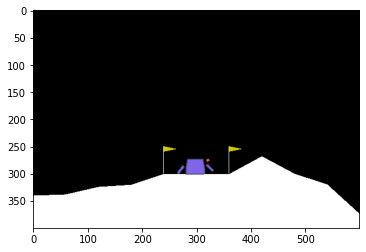

In [32]:
from gym.wrappers import Monitor

vdo_path = 'video_rl/'
env = Monitor(gym.make('LunarLander-v2'), vdo_path, force=True)
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

simulate_episode_render(env, optimal_policy)

ipythondisplay.clear_output(wait=True)
env.close()

## Lab exercise

1. Try to do MC-Control using epsilon greedy policy in:
  - Black Jack environment
  - Cart Pole environment
2. For BlackJack, find the winning percentage with optimal policy.
3. For Cart Pole, run the environment with optimal policy and record it as VDO.
4. Explain why MC-control is not good for LunarLander and CartPole.